In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from mpl_toolkits.mplot3d import Axes3D  # Necessary for 3D plotting
import matplotlib.lines as mlines
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import Video
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import os


In [8]:
def set_axes_equal(ax):
    """
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

Visualize positions and rotations at one timestep

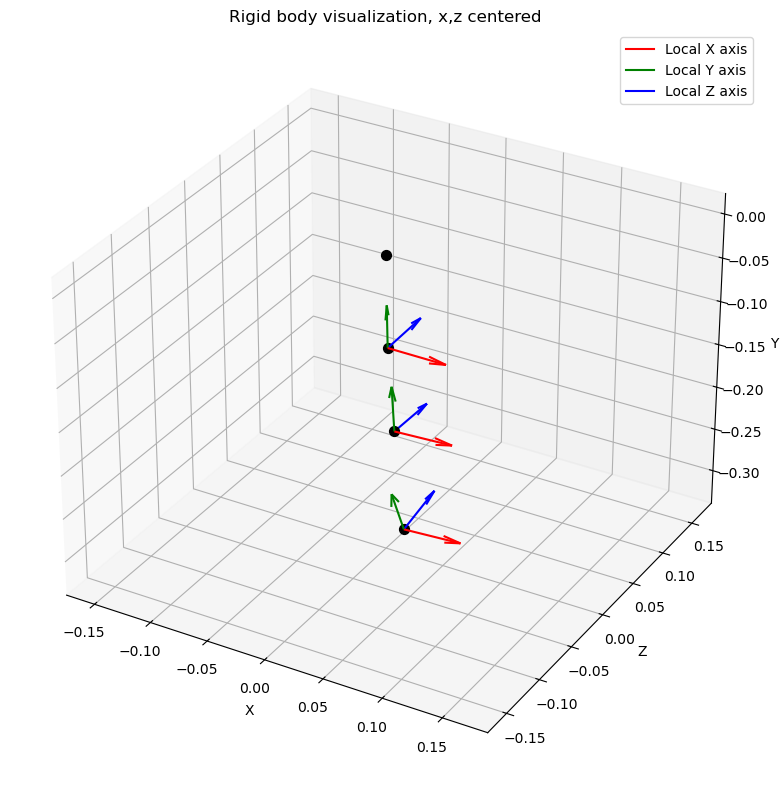

In [13]:
# Load the CSV file
df = pd.read_csv('../data/trajectories/dynamic/observations_controlled_102.csv')

# Select the first timestamp (row)
row = df.iloc[0]

# Get full current position vector
current_positions = np.array([
    row['x1'], row['y1'], row['z1'],
    row['x2'], row['y2'], row['z2'],
    row['x3'], row['y3'], row['z3']
])
rest_positions_xz = np.array([0.10056, 0.0, 0.10350, 0.09808, 0.0, 0.10645, 0.09242, 0.0, 0.09713])

# Subtract rest pose
relative_positions = current_positions - rest_positions_xz

# Initialize the 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Define axis colors
axis_colors = ['r', 'g', 'b']  # x=red, y=green, z=blue

# Define axis length for visualization
axis_length = 0.05  # Adjust as needed

# Process each rigid body
for i in range(1, 4):
    # Extract position
    pos = relative_positions[3 * (i - 1):3 * i]

    # Extract quaternion (OptiTrack format: x, y, z, w)
    quat = np.array([row[f'qx{i}'], row[f'qy{i}'], row[f'qz{i}'], row[f'w{i}']])

    # Create rotation object
    rotation = R.from_quat(quat)

    # Define local axes
    local_axes = np.identity(3)  # 3x3 identity matrix representing x, y, z axes

    # Rotate local axes to global orientation
    global_axes = rotation.apply(local_axes)

    # Plot the position
    ax.scatter(pos[0], pos[2], pos[1], color='k', s=50)

    # Plot the orientation axes
    for axis, color in zip(global_axes, axis_colors):
        ax.quiver(pos[0], pos[2], pos[1], axis[0], axis[2], axis[1], length=axis_length, color=color)

# marker at origin
ax.scatter(0, 0, 0, color='k', s=50, label='Trunk Origin')

# Set plot labels and limits
ax.set_xlabel('X')
ax.set_ylabel('Z')  
ax.set_zlabel('Y')  # Y is up down
ax.set_title('Rigid body visualization, x,z centered')
set_axes_equal(ax)

# Create proxy artists for legend
x_axis_legend = mlines.Line2D([], [], color='r', label='Local X axis')
y_axis_legend = mlines.Line2D([], [], color='g', label='Local Y axis')
z_axis_legend = mlines.Line2D([], [], color='b', label='Local Z axis')

# Add legend to the plot
ax.legend(handles=[x_axis_legend, y_axis_legend, z_axis_legend])

plt.tight_layout()
plt.show()


Animate the position and rotation of the trunk over time with matplotlib

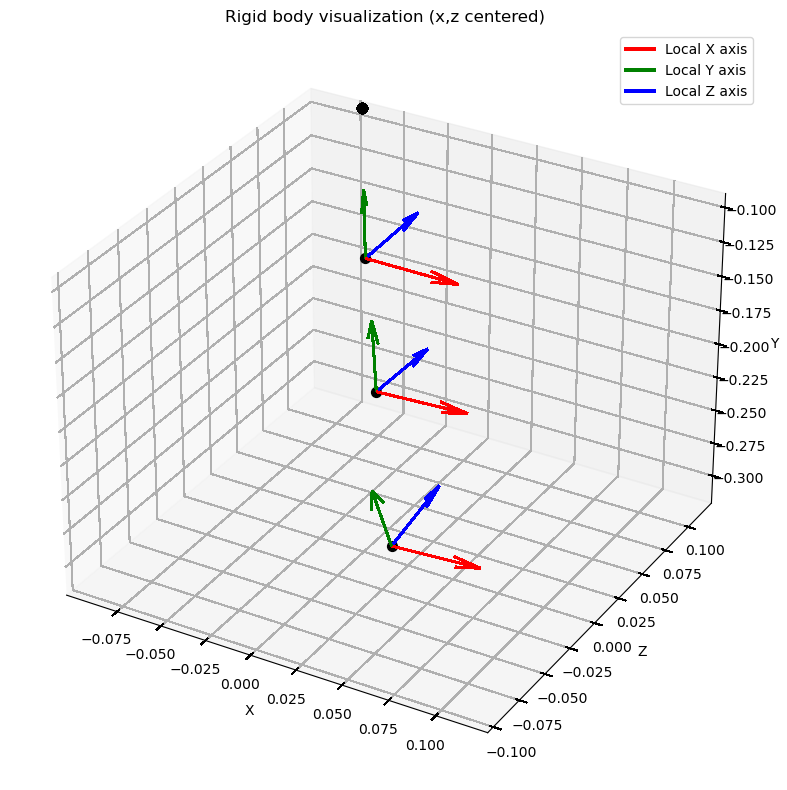

In [23]:
# === Load data ===
df = pd.read_csv('../data/trajectories/dynamic/observations_controlled_102.csv')
start_idx = 0  # for example, 1s in
end_idx = 1000  # for example, 2s in
frame_skip = 10  # keep every 10th frame - 10 Hz effective rate
df_slice = df.iloc[start_idx:end_idx:frame_skip]
# at frame skip = 10, 10 s vid takes 20 seconds to generate


# === Parameters ===
axis_colors = ['r', 'g', 'b']  # Local x, y, z
axis_length = 0.05
playback_speed = 1.0  # 1.0 = real-time at 100Hz
rest_positions_xz = np.array([
    0.10056, 0.0, 0.10350,
    0.09808, 0.0, 0.10645,
    0.09242, 0.0, 0.09713
])

# === Setup plot ===
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.set_title('Rigid body visualization (x,z centered)')

# Legend
x_axis_legend = mlines.Line2D([], [], color='r', label='Local X axis')
y_axis_legend = mlines.Line2D([], [], color='g', label='Local Y axis')
z_axis_legend = mlines.Line2D([], [], color='b', label='Local Z axis')
ax.legend(handles=[x_axis_legend, y_axis_legend, z_axis_legend])

# Init artists
scatters = []
quivers = []

for _ in range(3):  # 3 rigid bodies
    scat = ax.scatter([], [], [], color='k', s=50)
    scatters.append(scat)
    q_axes = [ax.quiver(0, 0, 0, 0, 0, 0, color=c) for c in axis_colors]
    quivers.append(q_axes)

# === Animation update ===
def update(frame_idx):
    row = df_slice.iloc[frame_idx]
    current_positions = np.array([
        row['x1'], row['y1'], row['z1'],
        row['x2'], row['y2'], row['z2'],
        row['x3'], row['y3'], row['z3']
    ])
    relative_positions = current_positions - rest_positions_xz

    for i in range(3):
        pos = relative_positions[3 * i : 3 * (i + 1)]
        quat = np.array([row[f'qx{i+1}'], row[f'qy{i+1}'], row[f'qz{i+1}'], row[f'w{i+1}']])
        rotation = R.from_quat(quat)
        global_axes = rotation.apply(np.identity(3))

        # Swap Y and Z to make Y vertical
        pos_plot = [pos[0], pos[2], pos[1]]
        axes_plot = global_axes[:, [0, 2, 1]]

        # Update scatter
        scatters[i]._offsets3d = ([pos_plot[0]], [pos_plot[1]], [pos_plot[2]])

        # Clear old quivers and add new
        for q in quivers[i]:
            q.remove()
        quivers[i] = []
        for axis_vec, color in zip(axes_plot, axis_colors):
            q = ax.quiver(
                pos_plot[0], pos_plot[1], pos_plot[2],
                axis_vec[0], axis_vec[1], axis_vec[2],
                length=axis_length, color=color
            )
            quivers[i].append(q)

    # marker at origin
    ax.scatter(0, 0, 0, color='k', s=50, label='Trunk Origin')

    return scatters + [q for qs in quivers for q in qs]

# Compute full relative positions across all timesteps
positions = df[[f'{axis}{i}' for i in range(1, 4) for axis in 'xyz']].values
relative_positions = positions - rest_positions_xz  # broadcasted subtraction
relative_positions = relative_positions.reshape((-1, 3))  # collapse frames and bodies

# Re-map y as vertical axis (i.e., swap y and z)
positions_plot = relative_positions[:, [0, 2, 1]]

# Compute axis limits
mins = positions_plot.min(axis=0)
maxs = positions_plot.max(axis=0)
centers = (mins + maxs) / 2
radii = (maxs - mins).max() / 2

ax.set_xlim([centers[0] - radii, centers[0] + radii])
ax.set_ylim([centers[1] - radii, centers[1] + radii])
ax.set_zlim([centers[2] - radii, centers[2] + radii])

# === Animate ===
interval_ms = 10 / playback_speed  # 100Hz data
ani = FuncAnimation(
    fig, update, frames=range(len(df_slice)), interval=interval_ms, blit=False
)

plt.tight_layout()
writer = FFMpegWriter(fps=int(100 / frame_skip * playback_speed))
ani.save('../data/visualizations/animation_controlled_102.mp4', writer=writer)
Video('../data/visualizations/animation_controlled_102.mp4')

Generate animation by saving images and using FFMPEG- much faster for long videos but requires running a command in command line

In [ ]:
# === Configuration ===
csv_path = '../data/trajectories/dynamic/observations_controlled_102.csv'
video_output_path = '../data/visualizations/animation_controlled_102_ffmpeg.mp4'
frames_dir = '../data/visualizations/frames'
os.makedirs(frames_dir, exist_ok=True)

start_idx = 0
end_idx = 10000
frame_skip = 10
# at frame skip = 10, 10 s vid takes 10 seconds to generate pngs and ~1s to generate video with ffmpeg command
#                      100s vid takes 1:38 aka 98 seconds to generate pngs ~1s to generate video with ffmpeg command



axis_length = 0.05
axis_colors = ['r', 'g', 'b']  # x=red, y=green, z=blue
rest_positions_xz = np.array([
    0.10056, 0.0, 0.10350,
    0.09808, 0.0, 0.10645,
    0.09242, 0.0, 0.09713
])

# === Load data ===
df = pd.read_csv(csv_path)
df_slice = df.iloc[start_idx:end_idx:frame_skip].reset_index(drop=True)

# === Precompute global axis limits ===
positions = df_slice[[f'{axis}{i}' for i in range(1, 4) for axis in 'xyz']].values
relative_positions = positions - rest_positions_xz
relative_positions = relative_positions.reshape((-1, 3))
positions_plot = relative_positions[:, [0, 2, 1]]  # x, z, y
mins = positions_plot.min(axis=0)
maxs = positions_plot.max(axis=0)
centers = (mins + maxs) / 2
radii = (maxs - mins).max() / 2
lims = [(c - radii, c + radii) for c in centers]

# === Start frame rendering ===
for frame_idx in range(len(df_slice)):
    row = df_slice.iloc[frame_idx]
    current_positions = np.array([
        row['x1'], row['y1'], row['z1'],
        row['x2'], row['y2'], row['z2'],
        row['x3'], row['y3'], row['z3']
    ])
    relative_positions = current_positions - rest_positions_xz

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.set_xlim(lims[0])
    ax.set_ylim(lims[1])
    ax.set_zlim(lims[2])
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_zlabel('Y')
    ax.set_title('Rigid Body Animation (Frame {})'.format(frame_idx))

    # Add trunk origin marker
    ax.scatter(0, 0, 0, color='k', s=50, label='Trunk Origin')

    # Plot each rigid body
    for i in range(1, 4):
        pos = relative_positions[3 * (i - 1):3 * i]
        quat = np.array([row[f'qx{i}'], row[f'qy{i}'], row[f'qz{i}'], row[f'w{i}']])
        rotation = R.from_quat(quat)
        global_axes = rotation.apply(np.identity(3))

        # Re-map y as up
        pos_plot = [pos[0], pos[2], pos[1]]
        axes_plot = global_axes[:, [0, 2, 1]]  # x stays, y <-> z

        ax.scatter(pos_plot[0], pos_plot[1], pos_plot[2], color='k', s=50)

        for axis_vec, color in zip(axes_plot, axis_colors):
            start = pos_plot
            end = pos_plot + axis_vec * axis_length
            ax.plot([start[0], end[0]],
                    [start[1], end[1]],
                    [start[2], end[2]],
                    color=color, linewidth=2)

    # Legend
    x_axis_legend = mlines.Line2D([], [], color='r', label='Local X axis')
    y_axis_legend = mlines.Line2D([], [], color='g', label='Local Y axis')
    z_axis_legend = mlines.Line2D([], [], color='b', label='Local Z axis')
    ax.legend(handles=[x_axis_legend, y_axis_legend, z_axis_legend])

    plt.tight_layout()
    frame_path = os.path.join(frames_dir, f'frame_{frame_idx:05d}.png')
    plt.savefig(frame_path, dpi=100)
    plt.close(fig)

# At this point, frames are saved. User should run ffmpeg command:
# ffmpeg -r 10 -i ../data/visualizations/frames/frame_%05d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p ../data/visualizations/animation_controlled_102_line.mp4